In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from PIL import Image

In [4]:
# Unzip the dataset
!unzip -q "/content/project.zip" -d "/content/project"

In [5]:
# Set the correct data directory
import os
from pathlib import Path

data_dir = Path("/content/project/Garbage classification/Garbage classification")
print("Classes found:", os.listdir(data_dir))

Classes found: ['cardboard', 'trash', 'paper', 'glass', 'metal', 'plastic']


In [6]:
# Count images per class
classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [7]:
for c in classes:
    count = len(list((data_dir / c).glob("*.jpg")))
    print(f"{c:9} : {count} images")

cardboard : 403 images
glass     : 501 images
metal     : 410 images
paper     : 594 images
plastic   : 482 images
trash     : 137 images


## EDA

In [8]:
# Class distribution
counts = {}
for c in classes:
    counts[c] = len(list((data_dir / c).glob("*.jpg")))

In [9]:
df_counts = pd.DataFrame(list(counts.items()), columns=['Class', 'Count']).sort_values('Count', ascending=False)

In [10]:
df_counts.head(6)

,Class,Count
3,paper,594
1,glass,501
4,plastic,482
2,metal,410
0,cardboard,403
5,trash,137


/tmp/ipython-input-1473388427.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Class', y='Count', data=df_counts, palette='viridis')


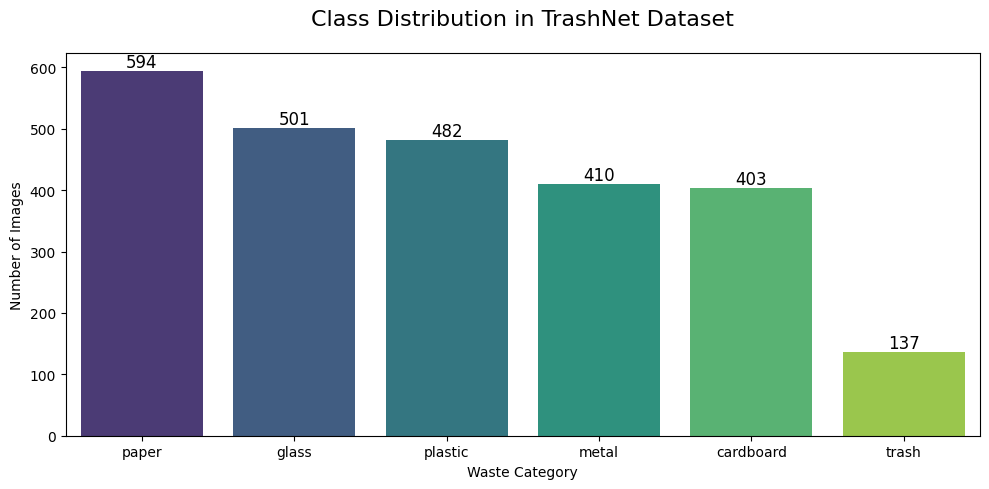

In [11]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='Class', y='Count', data=df_counts, palette='viridis')
ax.set_title('Class Distribution in TrashNet Dataset', fontsize=16, pad=20)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=12)
plt.ylabel('Number of Images')
plt.xlabel('Waste Category')
plt.tight_layout()
plt.show()

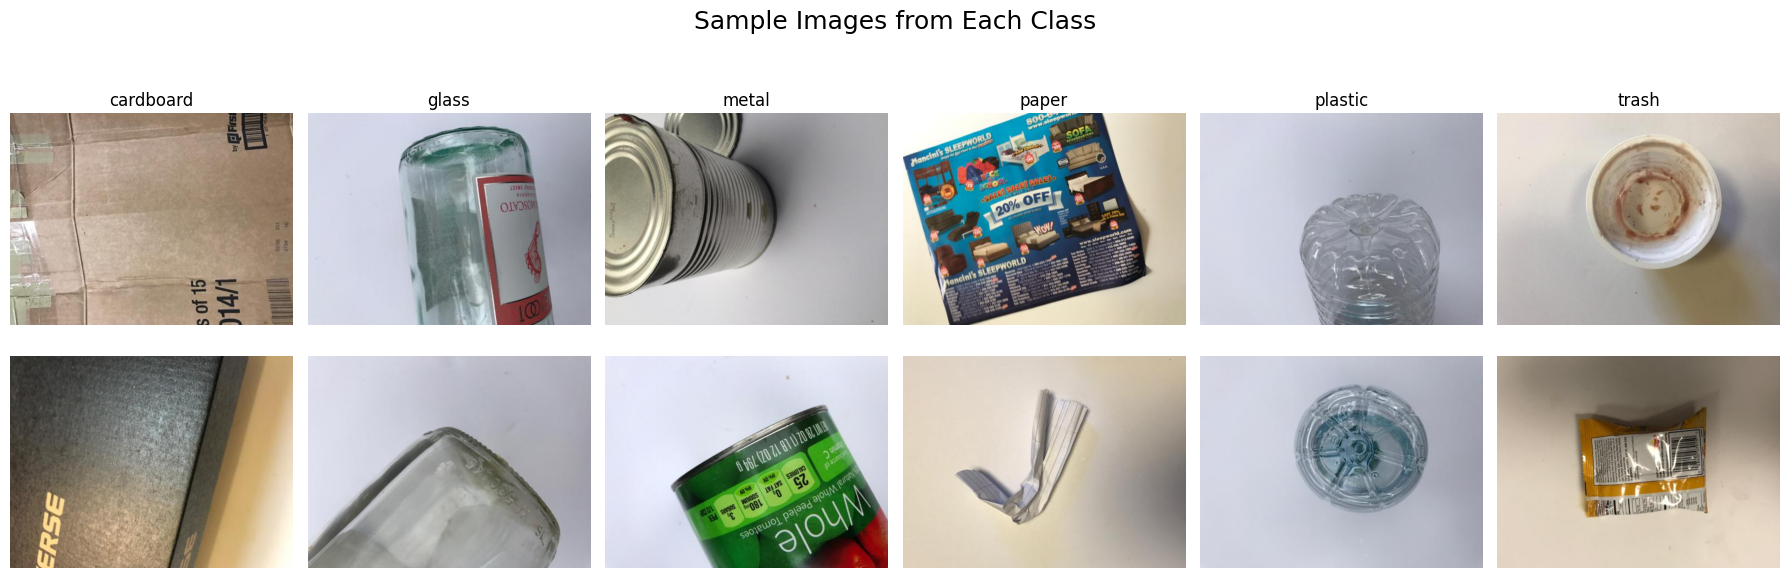

In [12]:
# Sample images (2 per class)
fig, axes = plt.subplots(2, 6, figsize=(18, 6))
fig.suptitle('Sample Images from Each Class', fontsize=18, y=1.02)

for i, cls in enumerate(classes):
    img_files = list((data_dir / cls).glob("*.jpg"))[:2]
    for j, img_path in enumerate(img_files):
        img = Image.open(img_path)
        axes[j, i].imshow(img)
        axes[j, i].set_title(cls if j == 0 else "")
        axes[j, i].axis('off')
plt.tight_layout()
plt.show()

In [13]:
# Image dimensions distribution
widths, heights = [], []
for c in classes:
    for img_path in (data_dir / c).glob("*.jpg"):
        with Image.open(img_path) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)

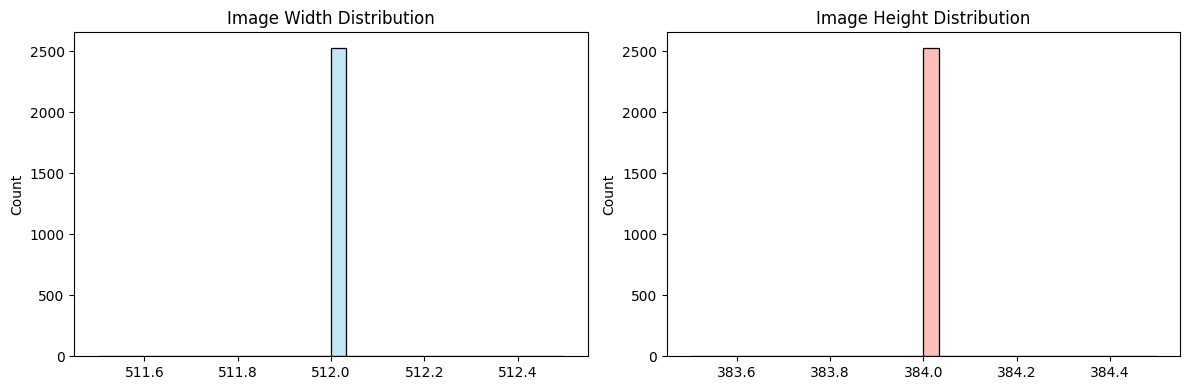

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(widths, bins=30, kde=True, color='skyblue')
plt.title('Image Width Distribution')
plt.subplot(1, 2, 2)
sns.histplot(heights, bins=30, kde=True, color='salmon')
plt.title('Image Height Distribution')
plt.tight_layout()
plt.show()

In [15]:
print(f"Width  → min: {min(widths)}, max: {max(widths)}, mean: {np.mean(widths):.1f}")
print(f"Height → min: {min(heights)}, max: {max(heights)}, mean: {np.mean(heights):.1f}")

Width  → min: 512, max: 512, mean: 512.0
Height → min: 384, max: 384, mean: 384.0


In [16]:
# Quick check for obviously corrupt files
corrupt = 0
for c in classes:
    for img_path in (data_dir / c).glob("*.jpg"):
        try:
            img = Image.open(img_path)
            img.verify()
        except:
            print(f"Corrupt: {img_path}")
            corrupt += 1
print(f"Found {corrupt} corrupt files")

Found 0 corrupt files


## STRATIFIED SPLIT (80/10/10)

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
filepaths = []
labels = []
for c in classes:
    files = list((data_dir / c).glob("*.jpg"))
    filepaths.extend([str(f) for f in files])
    labels.extend([c] * len(files))

In [19]:
df = pd.DataFrame({'filepath': filepaths, 'label': labels})

In [20]:
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df   = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

In [21]:
print(f"\nFinal split → Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")


Final split → Train: 2021 | Val: 253 | Test: 253


In [22]:
!mkdir -p /content/project/splits

In [23]:
train_df.to_csv("/content/project/splits/train.csv", index=False)
val_df.to_csv("/content/project/splits/val.csv", index=False)
test_df.to_csv("/content/project/splits/test.csv", index=False)

## CLASS IMBALANCE HANDLING + GENERATORS

In [25]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 728.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 125.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 115.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.7 MB/s eta 0:00:00


In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [27]:
# Compute class weights (inverse frequency – most common method)
class_counts = df_counts.set_index('Class').loc[classes]['Count'].values
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=labels
)

In [28]:
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

In [29]:
print("Class weights (will be passed to model.fit):")
for i, cls in enumerate(classes):
    print(f"  {cls:9} → {class_weights[i]:.2f}x")

Class weights (will be passed to model.fit):
  cardboard → 1.05x
  glass     → 0.84x
  metal     → 1.03x
  paper     → 0.71x
  plastic   → 0.87x
  trash     → 3.07x


In [30]:
# Generators (augmentation only on training set)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

In [31]:
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [32]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [33]:
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)


Found 2021 validated image filenames belonging to 6 classes.


In [34]:

val_gen = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)



Found 253 validated image filenames belonging to 6 classes.


In [35]:
test_gen = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 253 validated image filenames belonging to 6 classes.


In [36]:

print(f"\nImbalance handling strategy chosen:")
print("   → Class weighting (balanced)      ✓")
print("   → Stronger data augmentation      ✓")
print("   → Stratified splits preserved     ✓")


Imbalance handling strategy chosen:
   → Class weighting (balanced)      ✓
   → Stronger data augmentation      ✓
   → Stratified splits preserved     ✓


# IMPORTANT NOTE FOR MODEL TRAINING

We have severe class imbalance (trash class has only ~137 images vs. paper ~594).

To properly handle this, you **MUST** include the pre-computed class weights (in the code above) when calling model.fit:

```python
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,                    # or however many you choose
    class_weight=class_weight_dict,   # ← THIS IS CRITICAL FOR IMBALANCE!
    callbacks=[early_stopping, reduce_lr, model_checkpoint, ...]
)

In [38]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from sklearn.utils import class_weight
from collections import Counter
import os

# --- 0. Configuration Variables (Adjust these as needed) ---

# Assuming you have 6 classes (common for trash datasets)
NUM_CLASSES = 6
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
INITIAL_LEARNING_RATE = 0.0001
EPOCHS = 50 # Early Stopping will likely stop training before this number

# --- 1. Model Definition (Using Transfer Learning) ---

# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(
    input_shape=IMAGE_SIZE + (3,),
    include_top=False, # Exclude the final classification layer
    weights='imagenet' # Use weights trained on the massive ImageNet dataset
)

# Freeze the base layers so only the new layers are trained initially
base_model.trainable = False

# Create the final model architecture
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Reduces 3D feature maps to a 1D feature vector
    Dense(NUM_CLASSES, activation='softmax') # Output layer for multi-class classification
])

# 1c. Compile the model
# Adam is a solid default optimizer for deep learning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model Architecture:")
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [39]:
# --- 2. Compute Class Weights ---

# The generator objects (train_gen, val_gen) must be available in this scope.
# Replace 'train_gen' with the name of your actual training data generator.

# 2a. Extract the integer labels from the training generator
y_train_labels = train_gen.classes
unique_classes = np.unique(y_train_labels)

# 2b. Compute 'balanced' class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train_labels
)

# 2c. Convert the array of weights into the dictionary format required by Keras
class_weight_dict = dict(enumerate(weights))

print("-" * 50)
print("Class Imbalance Handled:")
print(f"Original class counts: {Counter(y_train_labels)}")
print(f"Calculated class_weight_dict: {class_weight_dict}")
print(f"Weights will penalize errors on minority classes (high weight) more heavily.")
print("-" * 50)

--------------------------------------------------
Class Imbalance Handled:
Original class counts: Counter({3: 475, 1: 401, 4: 385, 2: 328, 0: 322, 5: 110})
Calculated class_weight_dict: {0: np.float64(1.0460662525879918), 1: np.float64(0.8399833748960931), 2: np.float64(1.026930894308943), 3: np.float64(0.7091228070175438), 4: np.float64(0.8748917748917749), 5: np.float64(3.062121212121212)}
Weights will penalize errors on minority classes (high weight) more heavily.
--------------------------------------------------


In [40]:
# --- 3. Define Optimal Training Callbacks ---

# Early Stopping: Prevents overfitting and saves time
early_stopping = EarlyStopping(
    monitor='val_loss',             # Monitor the validation loss
    patience=10,                    # Stop if no improvement after 10 epochs
    restore_best_weights=True,      # Keep the best weights found
    verbose=1
)

# Learning Rate Scheduler: Helps fine-tune and stabilize convergence
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,                     # Reduce LR by 80%
    patience=5,                     # Wait 5 epochs for improvement before reducing
    min_lr=1e-7,
    verbose=1
)

# Model Checkpoint: Saves the best performing model
model_checkpoint = ModelCheckpoint(
    filepath='best_model_class_weighted.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

callbacks_list = [early_stopping, reduce_lr, model_checkpoint]

# --- 4. Train the Model ---

# Calculate steps based on generator samples and batch size
steps_per_epoch = train_gen.samples // BATCH_SIZE
validation_steps = val_gen.samples // BATCH_SIZE

history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=validation_steps,

    # ⭐ CRITICAL STEP: Include the computed class weights ⭐
    class_weight=class_weight_dict,

    callbacks=callbacks_list
)

print("\nTraining complete. The best model, incorporating class weights, is saved as 'best_model_class_weighted.h5'.")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.2073 - loss: 1.9259
Epoch 1: val_accuracy improved from -inf to 0.29911, saving model to best_model_class_weighted.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 748ms/step - accuracy: 0.2080 - loss: 1.9241 - val_accuracy: 0.2991 - val_loss: 1.6870 - learning_rate: 1.0000e-04
Epoch 2/50
 1/63 ━━━━━━━━━━━━━━━━━━━━ 31s 500ms/step - accuracy: 0.2500 - loss: 2.2751

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.29911
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.2500 - loss: 2.2751 - val_accuracy: 0.2991 - val_loss: 1.6838 - learning_rate: 1.0000e-04
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.3980 - loss: 1.5580
Epoch 3: val_accuracy improved from 0.29911 to 0.42411, saving model to best_model_class_weighted.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 722ms/step - accuracy: 0.3983 - loss: 1.5575 - val_accuracy: 0.4241 - val_loss: 1.4262 - learning_rate: 1.0000e-04
Epoch 4/50
 1/63 ━━━━━━━━━━━━━━━━━━━━ 26s 435ms/step - accuracy: 0.4375 - loss: 1.2174
Epoch 4: val_accuracy did not improve from 0.42411
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.4375 - loss: 1.2174 - val_accuracy: 0.4196 - val_loss: 1.4214 - learning_rate: 1.0000e-04
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.4934 - loss: 1.3556
Epoch 5: val_accuracy improved from 0.42411 to 0.51786, saving model to best_model_class_weighted.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 727ms/step - accuracy: 0.4937 - loss: 1.3554 - val_accuracy: 0.5179 - val_loss: 1.2466 - learning_rate: 1.0000e-04
Epoch 6/50
 1/63 ━━━━━━━━━━━━━━━━━━━━ 26s 431ms/step - accuracy: 0.5000 - loss: 1.3487
Epoch 6: val_accuracy improved from 0.51786 to 0.52232, saving model to best_model_class_weighted.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.5000 - loss: 1.3487 - val_accuracy: 0.5223 - val_loss: 1.2433 - learning_rate: 1.0000e-04
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.5598 - loss: 1.1779
Epoch 7: val_accuracy improved from 0.52232 to 0.57589, saving model to best_model_class_weighted.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 732ms/step - accuracy: 0.5597 - loss: 1.1784 - val_accuracy: 0.5759 - val_loss: 1.1095 - learning_rate: 1.0000e-04
Epoch 8/50
 1/63 ━━━━━━━━━━━━━━━━━━━━ 31s 513ms/step - accuracy: 0.5312 - loss: 1.4941
Epoch 8: val_accuracy did not improve from 0.57589
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.5312 - loss: 1.4941 - val_accuracy: 0.5759 - val_loss: 1.1077 - learning_rate: 1.0000e-04
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.5901 - loss: 1.1565
Epoch 9: val_accuracy improved from 0.57589 to 0.64286, saving model to best_model_class_weighted.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 752ms/step - accuracy: 0.5902 - loss: 1.1561 - val_accuracy: 0.6429 - val_loss: 0.9992 - learning_rate: 1.0000e-04
Epoch 10/50
 1/63 ━━━━━━━━━━━━━━━━━━━━ 27s 442ms/step - accuracy: 0.7812 - loss: 0.9020
Epoch 10: val_accuracy did not improve from 0.64286
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7812 - loss: 0.9020 - val_accuracy: 0.6384 - val_loss: 0.9982 - learning_rate: 1.0000e-04
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.6030 - loss: 1.0805
Epoch 11: val_accuracy improved from 0.64286 to 0.64732, saving model to best_model_class_weighted.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 738ms/step - accuracy: 0.6033 - loss: 1.0798 - val_accuracy: 0.6473 - val_loss: 0.9277 - learning_rate: 1.0000e-04
Epoch 12/50
 1/63 ━━━━━━━━━━━━━━━━━━━━ 37s 612ms/step - accuracy: 0.6250 - loss: 1.1481
Epoch 12: val_accuracy did not improve from 0.64732
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.6250 - loss: 1.1481 - val_accuracy: 0.6473 - val_loss: 0.9269 - learning_rate: 1.0000e-04
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.6347 - loss: 0.9982
Epoch 13: val_accuracy improved from 0.64732 to 0.67411, saving model to best_model_class_weighted.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 732ms/step - accuracy: 0.6348 - loss: 0.9984 - val_accuracy: 0.6741 - val_loss: 0.8841 - learning_rate: 1.0000e-04
Epoch 14/50
 1/63 ━━━━━━━━━━━━━━━━━━━━ 27s 436ms/step - accuracy: 0.5625 - loss: 1.1643
Epoch 14: val_accuracy did not improve from 0.67411
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.5625 - loss: 1.1643 - val_accuracy: 0.6741 - val_loss: 0.8838 - learning_rate: 1.0000e-04
Epoch 15/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.6440 - loss: 0.9671
Epoch 15: val_accuracy improved from 0.67411 to 0.69196, saving model to best_model_class_weighted.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 743ms/step - accuracy: 0.6441 - loss: 0.9669 - val_accuracy: 0.6920 - val_loss: 0.8363 - learning_rate: 1.0000e-04
Epoch 16/50
 1/63 ━━━━━━━━━━━━━━━━━━━━ 27s 450ms/step - accuracy: 0.6250 - loss: 0.9818
Epoch 16: val_accuracy did not improve from 0.69196
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.6250 - loss: 0.9818 - val_accuracy: 0.6920 - val_loss: 0.8351 - learning_rate: 1.0000e-04
Epoch 17/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.6737 - loss: 0.9287
Epoch 17: val_accuracy improved from 0.69196 to 0.72321, saving model to best_model_class_weighted.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 735ms/step - accuracy: 0.6737 - loss: 0.9284 - val_accuracy: 0.7232 - val_loss: 0.7903 - learning_rate: 1.0000e-04
Epoch 18/50
 1/63 ━━━━━━━━━━━━━━━━━━━━ 26s 433ms/step - accuracy: 0.6875 - loss: 0.6815
Epoch 18: val_accuracy improved from 0.72321 to 0.72768, saving model to best_model_class_weighted.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.6875 - loss: 0.6815 - val_accuracy: 0.7277 - val_loss: 0.7894 - learning_rate: 1.0000e-04
Epoch 19/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.6832 - loss: 0.8726
Epoch 19: val_accuracy did not improve from 0.72768
63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 735ms/step - accuracy: 0.6831 - loss: 0.8731 - val_accuracy: 0.7188 - val_loss: 0.7620 - learning_rate: 1.0000e-04
Epoch 20/50
 1/63 ━━━━━━━━━━━━━━━━━━━━ 31s 509ms/step - accuracy: 0.6562 - loss: 0.7938
Epoch 20: val_accuracy did not improve from 0.72768
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.6562 - loss: 0.7938 - val_accuracy: 0.7232 - val_loss: 0.7610 - learning_rate: 1.0000e-04
Epoch 21/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.6997 - loss: 0.8478
Epoch 21: val_accuracy improved from 0.72768 to 0.74554, saving model to best_model_class_weighted.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 730ms/step - accuracy: 0.6996 - loss: 0.8479 - val_accuracy: 0.7455 - val_loss: 0.7195 - learning_rate: 1.0000e-04
Epoch 22/50
 1/63 ━━━━━━━━━━━━━━━━━━━━ 27s 446ms/step - accuracy: 0.6875 - loss: 0.8179
Epoch 22: val_accuracy improved from 0.74554 to 0.75000, saving model to best_model_class_weighted.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.6875 - loss: 0.8179 - val_accuracy: 0.7500 - val_loss: 0.7201 - learning_rate: 1.0000e-04
Epoch 23/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.6966 - loss: 0.8101
Epoch 23: val_accuracy improved from 0.75000 to 0.75446, saving model to best_model_class_weighted.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 730ms/step - accuracy: 0.6965 - loss: 0.8104 - val_accuracy: 0.7545 - val_loss: 0.7010 - learning_rate: 1.0000e-04
Epoch 24/50
 1/63 ━━━━━━━━━━━━━━━━━━━━ 31s 511ms/step - accuracy: 0.7188 - loss: 0.6814
Epoch 24: val_accuracy did not improve from 0.75446
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.7188 - loss: 0.6814 - val_accuracy: 0.7545 - val_loss: 0.7003 - learning_rate: 1.0000e-04
Epoch 25/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.7134 - loss: 0.8107
Epoch 25: val_accuracy improved from 0.75446 to 0.78125, saving model to best_model_class_weighted.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 722ms/step - accuracy: 0.7134 - loss: 0.8106 - val_accuracy: 0.7812 - val_loss: 0.6683 - learning_rate: 1.0000e-04
Epoch 26/50
 1/63 ━━━━━━━━━━━━━━━━━━━━ 27s 440ms/step - accuracy: 0.5938 - loss: 0.9839
Epoch 26: val_accuracy did not improve from 0.78125
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.5938 - loss: 0.9839 - val_accuracy: 0.7812 - val_loss: 0.6682 - learning_rate: 1.0000e-04
Epoch 27/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.7222 - loss: 0.8087
Epoch 27: val_accuracy improved from 0.78125 to 0.79018, saving model to best_model_class_weighted.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 728ms/step - accuracy: 0.7220 - loss: 0.8087 - val_accuracy: 0.7902 - val_loss: 0.6505 - learning_rate: 1.0000e-04
Epoch 28/50
 1/63 ━━━━━━━━━━━━━━━━━━━━ 26s 434ms/step - accuracy: 0.8750 - loss: 0.4777
Epoch 28: val_accuracy did not improve from 0.79018
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.8750 - loss: 0.4777 - val_accuracy: 0.7902 - val_loss: 0.6507 - learning_rate: 1.0000e-04
Epoch 29/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.7205 - loss: 0.7725
Epoch 29: val_accuracy did not improve from 0.79018
63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 731ms/step - accuracy: 0.7205 - loss: 0.7726 - val_accuracy: 0.7812 - val_loss: 0.6363 - learning_rate: 1.0000e-04
Epoch 30/50
 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 1.0000 - loss: 0.4137
Epoch 30: val_accuracy did not improve from 0.79018
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 1.0000 - loss: 0.4137 - val_accuracy: 0.7812 - val_loss: 0.6358 - learning_rate: 1.0000e-04
Epo

63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 706ms/step - accuracy: 0.7478 - loss: 0.6961 - val_accuracy: 0.7991 - val_loss: 0.6087 - learning_rate: 1.0000e-04
Epoch 34/50
 1/63 ━━━━━━━━━━━━━━━━━━━━ 27s 442ms/step - accuracy: 0.6562 - loss: 0.8487
Epoch 34: val_accuracy did not improve from 0.79911
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.6562 - loss: 0.8487 - val_accuracy: 0.7991 - val_loss: 0.6085 - learning_rate: 1.0000e-04
Epoch 35/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.7293 - loss: 0.7547
Epoch 35: val_accuracy improved from 0.79911 to 0.80804, saving model to best_model_class_weighted.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 723ms/step - accuracy: 0.7296 - loss: 0.7542 - val_accuracy: 0.8080 - val_loss: 0.6007 - learning_rate: 1.0000e-04
Epoch 36/50
 1/63 ━━━━━━━━━━━━━━━━━━━━ 27s 444ms/step - accuracy: 0.7188 - loss: 0.5736
Epoch 36: val_accuracy did not improve from 0.80804
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7188 - loss: 0.5736 - val_accuracy: 0.8080 - val_loss: 0.6001 - learning_rate: 1.0000e-04
Epoch 37/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.7540 - loss: 0.6846
Epoch 37: val_accuracy did not improve from 0.80804
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 720ms/step - accuracy: 0.7539 - loss: 0.6850 - val_accuracy: 0.8036 - val_loss: 0.5805 - learning_rate: 1.0000e-04
Epoch 38/50
 1/63 ━━━━━━━━━━━━━━━━━━━━ 34s 563ms/step - accuracy: 0.7188 - loss: 0.6205
Epoch 38: val_accuracy improved from 0.80804 to 0.81250, saving model to best_model_class_weighted.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.7188 - loss: 0.6205 - val_accuracy: 0.8125 - val_loss: 0.5795 - learning_rate: 1.0000e-04
Epoch 39/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.7781 - loss: 0.6968
Epoch 39: val_accuracy improved from 0.81250 to 0.81696, saving model to best_model_class_weighted.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 728ms/step - accuracy: 0.7779 - loss: 0.6968 - val_accuracy: 0.8170 - val_loss: 0.5658 - learning_rate: 1.0000e-04
Epoch 40/50
 1/63 ━━━━━━━━━━━━━━━━━━━━ 27s 436ms/step - accuracy: 0.7812 - loss: 0.5740
Epoch 40: val_accuracy did not improve from 0.81696
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.7812 - loss: 0.5740 - val_accuracy: 0.8170 - val_loss: 0.5660 - learning_rate: 1.0000e-04
Epoch 41/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.7772 - loss: 0.6596
Epoch 41: val_accuracy did not improve from 0.81696
63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 728ms/step - accuracy: 0.7771 - loss: 0.6599 - val_accuracy: 0.8080 - val_loss: 0.5636 - learning_rate: 1.0000e-04
Epoch 42/50
 1/63 ━━━━━━━━━━━━━━━━━━━━ 30s 484ms/step - accuracy: 0.7812 - loss: 0.6938
Epoch 42: val_accuracy did not improve from 0.81696
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.7812 - loss: 0.6938 - val_accuracy: 0.8080 - val_loss: 0.5636 - learning_rate: 1.0000e-04
E

63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 723ms/step - accuracy: 0.7839 - loss: 0.6505 - val_accuracy: 0.8259 - val_loss: 0.5441 - learning_rate: 1.0000e-04
Epoch 48/50
 1/63 ━━━━━━━━━━━━━━━━━━━━ 27s 445ms/step - accuracy: 0.7812 - loss: 0.7077
Epoch 48: val_accuracy did not improve from 0.82589
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.7812 - loss: 0.7077 - val_accuracy: 0.8259 - val_loss: 0.5446 - learning_rate: 1.0000e-04
Epoch 49/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.7583 - loss: 0.6576
Epoch 49: val_accuracy did not improve from 0.82589
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 717ms/step - accuracy: 0.7586 - loss: 0.6572 - val_accuracy: 0.8214 - val_loss: 0.5300 - learning_rate: 1.0000e-04
Epoch 50/50
 1/63 ━━━━━━━━━━━━━━━━━━━━ 30s 490ms/step - accuracy: 0.7188 - loss: 0.7285
Epoch 50: val_accuracy did not improve from 0.82589
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.7188 - loss: 0.7285 - val_accuracy: 0.8214 - val_loss: 0.5303 - learning_rate: 1.0000e-04
R